# Tweede Kamer speeches


Alle Tweede Kamer parlementaire debatten van 1995 t/m juni-2019 zijn in een data set verzameld. Dat is het werk van:

Rauh, Christian; Schwalbach, Jan, 2020, "0_RauhSchwalbach_2020_ParlSpeechV2_ReleaseNote.pdf", The ParlSpeech V2 data set: Full-text corpora of 6.3 million parliamentary speeches in the key legislative chambers of nine representative democracies, https://doi.org/10.7910/DVN/L4OAKN/C2TWCZ, Harvard Dataverse, V1

Voor meer informatie [zie deze site](https://dataverse.harvard.edu/dataset.xhtml?persistentId=doi:10.7910/DVN/L4OAKN).

## Analyze mogelijkheden

* Metadata analyse
* Topic modeling
* Word2Vec
* pretrained TF senetence model
* predictive model. Bijvoorbeeld Classificatie naar partij
* Transformers text generation
* en veel meer.....



In [81]:
import pandas as pd
import numpy as np
import gensim
import plotly.express as px
import seaborn as sns
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import CountVectorizer

## IMPORT Data

The original data on the webiste was an R rds file, I imported that in R and saved it as csv, then zipped it. But the zip file was too large to put on GitHub so I used the command line tool split to create 24 Mb chuncks. CorpusTweedeKamera .... CorpusTweedekamerl. You need to put those chuncks to one zip again.


In [6]:
## put data chuncks in one zip file
!cat data/CorpusTweedeKamer* > CorpusTweedeKamer.zip

In [2]:
%%time
tweede_kamer = pd.read_csv("CorpusTweedeKamer.zip")

CPU times: user 12.3 s, sys: 724 ms, total: 13 s
Wall time: 13.1 s


In [31]:
tweede_kamer = (
    tweede_kamer
    .assign(datum = pd.to_datetime(tweede_kamer.date))
    .assign(speaker = tweede_kamer.speaker.str.lower())
)

In [113]:
tweede_kamer.sort_values(["datum", "speechnumber"])

,date,agenda,speechnumber,speaker,party,party.facts.id,chair,terms,text,parliament,iso3country,datum
0,1994-12-20,NaN,1,marijnissen,SP,1363.0,False,561,Mijnheer de voorzitter! Ik vertel de minister ...,NL-TweedeKamer,NLD,1994-12-20
1,1994-12-20,NaN,2,melkert,PvdA,1234.0,False,706,Mijnheer de voorzitter! Mag ik allereerst de h...,NL-TweedeKamer,NLD,1994-12-20
2,1994-12-20,NaN,3,marijnissen,SP,1363.0,False,304,Mijnheer de voorzitter! Hoewel ik het antwoord...,NL-TweedeKamer,NLD,1994-12-20
3,1994-12-20,NaN,4,melkert,PvdA,1234.0,False,374,Mijnheer de voorzitter! Wat is onrechtvaardig?...,NL-TweedeKamer,NLD,1994-12-20
4,1994-12-20,NaN,5,rosenmöller,GL,1537.0,False,412,Voorzitter! Afgelopen zaterdag stond in NRC Ha...,NL-TweedeKamer,NLD,1994-12-20
...,...,...,...,...,...,...,...,...,...,...,...,...
1143361,2019-07-04,NaN,965,staatssecretaris broekers-knol,NaN,NaN,False,142,Dan de motie op stuk nr. 2519 van de heer Hidd...,NL-TweedeKamer,NLD,2019-07-04
1143362,2019-07-04,NaN,966,de voorzitter,NaN,NaN,True,3,Dank u wel.,NL-TweedeKamer,NLD,2019-07-04
1143363,2019-07-04,NaN,967,de voorzitter,NaN,NaN,True,62,Over exact 60 minuten gaan wij stemmen over de...,NL-TweedeKamer,NLD,2019-07-04
1143364,2019-07-04,NaN,968,mevrouw van toorenburg,CDA,1157.0,False,21,Toch nog even — misschien is het allemaal afge...,NL-TweedeKamer,NLD,2019-07-04


## Metadata analyse
Non NLP Analysis on the parlement speech data

In [6]:
partijen = (
    tweede_kamer.party
    .value_counts()
    .to_frame()
    .reset_index()
)

In [7]:
fig = px.bar(partijen,x= "index", y = "party", width = 1000, title = "aantal speeches per partij")
fig

In [33]:
sprekers =(
    tweede_kamer
    .query('speaker.str.contains("voorzitter") == False')
    .speaker
    .str.lower()
    .value_counts()
    .to_frame()
    .reset_index()
)

In [34]:
sprekers.head(10)

,index,speaker
0,rutte,9779
1,halsema,8794
2,pechtold,8172
3,van der vlies,7946
4,dittrich,7455
5,balkenende,7437
6,donner,7356
7,vendrik,7238
8,rouvoet,7204
9,rosenmöller,6873


In [35]:
fig = px.bar(sprekers.query('speaker > 2000'), x= "index", y = "speaker", width = 1500, height=700)
fig

In [36]:
perdag =(
    tweede_kamer
    .datum
    .value_counts()
    .to_frame()
    .reset_index()
)

In [37]:
perdag = perdag.sort_values("index")

In [40]:
px.line(perdag, x = "index", y ="datum", width= 1750)

## Gemiddelde lengte speech per partij en spreker

In [109]:
partijen_terms = (
    tweede_kamer
    .groupby("party")
    .agg({"terms": np.mean})
    .reset_index()
)

In [112]:
fig = px.bar(partijen_terms.sort_values("terms"), x= "party", y = "terms", width = 1500, height=700)
fig

In [118]:
partijen_terms = (
    tweede_kamer
    .groupby(["party", "speaker"])
    .agg({"terms": np.mean})
    .reset_index()
)

In [120]:
partijen_terms

,party,speaker,terms
0,50PLUS,de heer geleijnse,144.897436
1,50PLUS,de heer krol,167.892587
2,50PLUS,de heer van otterloo,206.440000
3,50PLUS,de heer van rooijen,154.387953
4,50PLUS,mevrouw sazias,144.747826
...,...,...,...
1438,other,zaandam,224.333333
1439,other,zalm,445.000000
1440,other,zijlstra,144.681818
1441,other,zonneveld,748.176471


In [132]:
fig = px.histogram(partijen_terms.query('terms < 1000'), x = "terms", width = 1500, height=1200, facet_col = "party", facet_col_wrap = 4)
fig

### Short speeches

In [99]:
shorttexts = tweede_kamer.query("terms < 4").dropna(subset = ["text"]).text

In [100]:
shorttexts

900812     Hartstikke goed.
900837                 Nee.
900862                 Nee.
900884       Niet door mij!
900891       Gaat u verder.
                 ...       
1143291         Dank u wel.
1143292         Wederzijds.
1143322              Prima.
1143350         Dank u wel.
1143362         Dank u wel.
Name: text, Length: 13793, dtype: object

In [101]:
vectorizer = CountVectorizer()
X = vectorizer.fit_transform(shorttexts)

In [102]:
freqs = vectorizer.vocabulary_

In [103]:
zz = pd.DataFrame(
    {
        "keys": np.array(list(freqs.keys())),
        "values": np.array(list(freqs.values()))
    }
)

In [104]:
zz.sort_values("values").tail(100)

,keys,values
225,welk,1621
138,welke,1622
749,welkzijn,1623
742,wellicht,1624
499,welnee,1625
...,...,...
923,özdil,1716
104,öztürk,1717
907,özütok,1718
1580,úw,1719


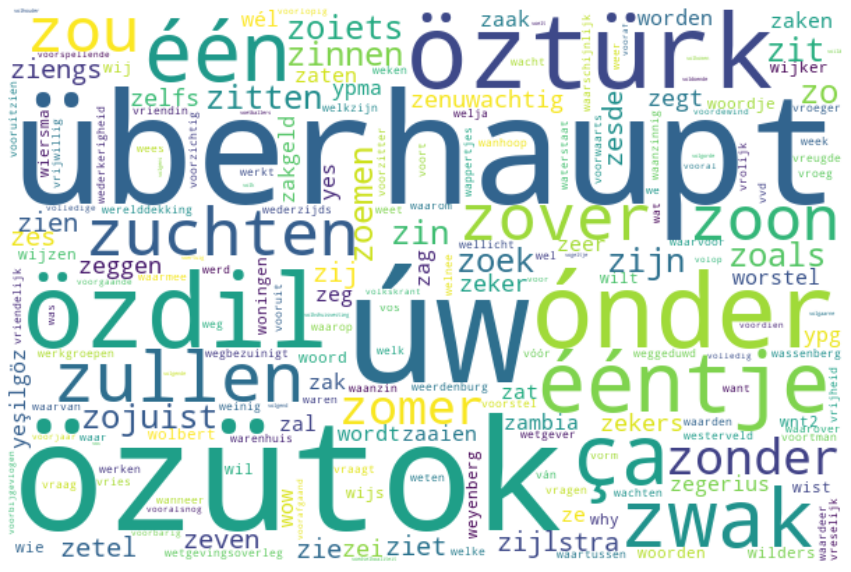

In [105]:
wordcloud = WordCloud( background_color="white", height=400, width=600).generate_from_frequencies(freqs)
plt.figure(figsize=(15,12))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()